# MNIST training notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import snntorch as snn 
from snntorch import spikegen
import snntorch.spikeplot as splt

## Load Datasets and DataLoaders

In [2]:
# Load Datasets
transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0,), (1,))
    ]
)
datapath = "../data"
train_dataset = MNIST(datapath, train=True, transform=transform, download=False)  # Change download=True first time
test_dataset = MNIST(datapath, train=False, transform=transform, download=False)

In [3]:
# Load Dataloaders
BATCH_SIZE = 1

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [4]:
train_dataset.train_data.shape, test_dataset.train_data.shape

/home/james/anaconda3/envs/ini/lib/python3.11/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

## Define Network

In [5]:
TAU = 5e-3
DT = 1  # ms
BETA = 0.9
THRESHOLD = 1.0
NUM_STEPS = 25

NUM_INPUTS = len(train_dataset.train_data[0].flatten())
NUM_HIDDENS = 1000  # Design choice
NUM_OUTPUTS = 10  # Number of output classes
print(f"NUM_INPUTS: {NUM_INPUTS}, NUM_HIDDENS: {NUM_HIDDENS}, NUM_OUTPUTS: {NUM_OUTPUTS}")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

NUM_INPUTS: 784, NUM_HIDDENS: 1000, NUM_OUTPUTS: 10


In [6]:
class Net(nn.Module):
    """Simple 3-layer, feed-forward SNN"""

    def __init__(self, num_inputs: int, num_hiddens: int, num_outputs: int, 
                 tau: float, dt, beta: float, threshold: float, num_steps: int):
        """Initialise hyperparameters and architecture"""
        super().__init__()  # Get good stuff from pytorch.nn.Module

        # Hyperparams
        self.tau = tau
        self.dt = dt
        self.beta = beta
        self.threshold = threshold
        self.num_steps = num_steps  # No. simulation steps for 1 example

        # Architecture
        self.fc1 = nn.Linear(in_features=num_inputs, out_features=num_hiddens)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(in_features=num_hiddens, out_features=num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x: torch.Tensor):
        """
        Parameters:
            x: Input tensor (time_index, BATCH_SIZE, features_unrolled)"""
        # Initialise membrane potential tensors
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Create arrays to store spikes over time
        spk2_rec = []
        mem2_rec = []

        # Iterate over all timesteps for 1 example
        for step in range(self.num_steps):
            # TODO: x is not spikes, but this generates effectively I = WX for input to LIF potential
            # Also same x is fed into network at each time, should be probabilistic spike over time instead, x[step] (index in time)
            cur1 = self.fc1(x)  
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            spk2_rec.append(spk2)  # Store spike outputs & membrane voltage
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec)
    
net = Net(num_inputs=NUM_INPUTS, num_hiddens=NUM_HIDDENS, num_outputs=NUM_OUTPUTS,
          tau=TAU, dt=DT, beta=BETA, threshold=THRESHOLD, num_steps=NUM_STEPS).to(device)

* `fc1` applies a linear transformation to all input pixels from the MNIST dataset;
* `lif1` integrates the weighted input over time, emitting a spike if the threshold condition is met;
* `fc2` applies a linear transformation to the output spikes of `lif1`;
* `lif2` is another spiking neuron layer, integrating the weighted spikes over time.

## Training

### Define accuracy metric

In [7]:
data, targets = next(iter(train_dataloader))
data.shape, targets.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1]))

In [8]:
def batch_prediction_accuracy(data: torch.Tensor, targets, net: nn.Module, train=False):
    """Classification accuracy
    
    Use rate coding. I.e. take neuron with highest firing rate (spike count) as predicted class.
    Parameters:
        data: batch of data, size (BATCH_SIZE, FEATURES). In this case (BATCH_SIZE, # Channels, H, W)
        targets:
        net: network to query
    """
    output_spikes, _ = net(data.view(BATCH_SIZE, -1))  # Flattens data to BATCH_SIZE x H*W
    _, idxs = output_spikes.sum(dim=0).max(1)  # Sum output spikes over time, then find max neuron
    acc = np.mean((targets == idxs).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

def train_printer(data, targets, net, epoch, counter, iter_counter,
                  loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    batch_prediction_accuracy(data, targets, net, train=True)
    batch_prediction_accuracy(test_data, test_targets, net, train=False)
    print("\n")

### Define Loss

In [9]:
# Use pytorch cross-entropy loss on membrane potentials of output neurons
# membrane_potentials_i -> softmax_i -> cross_entropy_i

loss = nn.CrossEntropyLoss()

In [10]:
LR = 5e-4
optimizer = torch.optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999))

### Train and evaluation pipeline for 1 minibatch

In [11]:
data, targets = next(iter(train_dataloader))
data = data.to(device)
targets = targets.to(device)

In [12]:
spk_rec, mem_rec = net(data.view(BATCH_SIZE, -1))
print(mem_rec.shape)  # 25 time steps, 128 samples in minibatch, 10 output features/classes

torch.Size([25, 1, 10])


In [13]:
mem_rec[0,0]  # For 1 timestep, for 1 example, 10 output membrane voltages

tensor([ 0.0130, -0.0208,  0.0007,  0.0024, -0.0157,  0.0129, -0.0272, -0.0207,
        -0.0086, -0.0116], grad_fn=<SelectBackward0>)

In [14]:
# Initialise loss value
dtype = torch.float
loss_val = torch.zeros((1), dtype=dtype, device=device)

for timestep in range(NUM_STEPS):
    loss_val += loss(mem_rec[timestep], targets)

print(f"Training loss: {loss_val.item():.3f}")

Training loss: 41.946


In [15]:
batch_prediction_accuracy(data, targets, net, train=True)

Train set accuracy for a single minibatch: 100.00%


In [16]:
# Single weight update iteration
optimizer.zero_grad()  # Clear previous gradients
loss_val.backward()
optimizer.step()

In [17]:
# Re print accuracy after training
spk_rec, mem_rec = net(data.view(BATCH_SIZE, -1))
loss_val = torch.zeros((1), dtype=dtype, device=device)

for timestep in range(NUM_STEPS):
    loss_val += loss(mem_rec[timestep], targets)

print(f"Training loss: {loss_val.item():.3f}")
batch_prediction_accuracy(data, targets, net, train=True)

Training loss: 23.522
Train set accuracy for a single minibatch: 100.00%


- Note loss has decreased after iteration

### Training loop

In [18]:
NUM_EPOCHS = 1

# Initialise tracking variables
counter = 0  # total iteration counter
train_loss_hist = []
test_loss_hist = []

# Outer Training loop
for epoch in range(NUM_EPOCHS):
    iter_counter = 0  # keep track of iterations within an epoch

    # Loop over each minibatch
    for data, targets in iter(train_dataloader):

        data = data.to(device)
        targets = targets.to(device)
        net.train()  # Set module to training mode

        # Forward pass
        spk_rec, mem_rec = net(data.view(BATCH_SIZE, -1))

        # Initialise loss and sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for timestep in range(NUM_STEPS):
            loss_val += loss(mem_rec[timestep], targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss
        train_loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():  # Disable gradient tracking when evaluating
            net.eval()  # Set net to eval mode
            test_data, test_targets = next(iter(test_dataloader))
            output_spikes, output_memb_pots = net(test_data.view(BATCH_SIZE, -1))

            test_loss = torch.zeros((1), dtype=dtype, device=device)

            for timestep in range(NUM_STEPS):
                test_loss += loss(output_memb_pots[timestep], test_targets)  # Note that loss values are summed/averaged over minibatch
            test_loss_hist.append(test_loss.item())

            # Print train/test loss and accuracy
            if counter % 50 == 0:
                train_printer(data, targets, net, epoch, counter,
                              iter_counter, train_loss_hist, test_loss_hist,
                              test_data, test_targets)
            counter += 1
            iter_counter += 1



Epoch 0, Iteration 0
Train Set Loss: 66.13
Test Set Loss: 47.93
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 0, Iteration 50
Train Set Loss: 33.21
Test Set Loss: 72.99
Train set accuracy for a single minibatch: 100.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 0, Iteration 100
Train Set Loss: 6.46
Test Set Loss: 7.50
Train set accuracy for a single minibatch: 100.00%
Test set accuracy for a single minibatch: 100.00%


Epoch 0, Iteration 150
Train Set Loss: 8.89
Test Set Loss: 4.60
Train set accuracy for a single minibatch: 100.00%
Test set accuracy for a single minibatch: 100.00%


Epoch 0, Iteration 200
Train Set Loss: 81.46
Test Set Loss: 131.17
Train set accuracy for a single minibatch: 0.00%
Test set accuracy for a single minibatch: 0.00%


Epoch 0, Iteration 250
Train Set Loss: 4.92
Test Set Loss: 32.67
Train set accuracy for a single minibatch: 100.00%
Test set accuracy for a single minibatch: 0.00%


Epoch

KeyboardInterrupt: 

## Plot Learning Curves

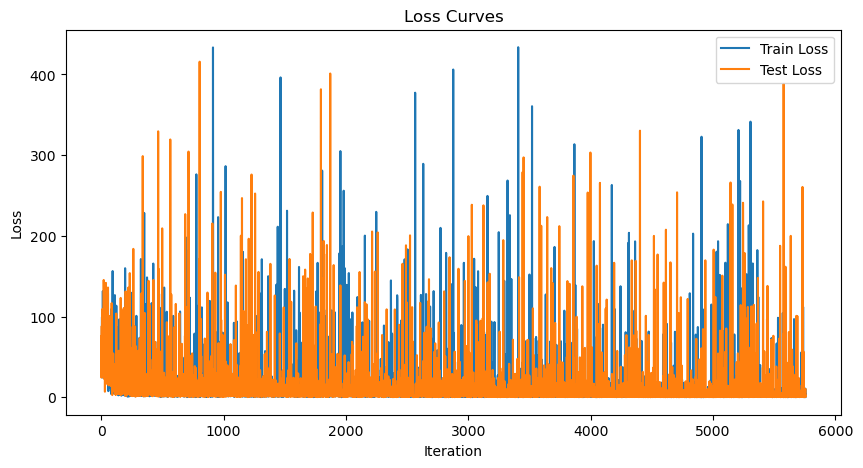

In [19]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(train_loss_hist)
plt.plot(test_loss_hist)
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

### Test set accuracy

Instead of computing loss, with is calculated based on membrane potential, use max firing rate to classify:

In [92]:
total = 0
correct = 0

# drop_last switched to False to keep all samples
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # forward pass
    test_spk, _ = net(data.view(data.size(0), -1))

    # calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 9616/10000
Test Set Accuracy: 96.16%
